# Data Programming cw 2 

## contents
- Introduction
- Aims and objectives
- Data acquisition
- Saving the dataset
- Data screening and cleaning
- High level look at the data and descriptive statistics
- Analysis
- Results
- Conclusion and discussion

## Introduction
This is a data analysis of the academic journal frontiers. The analysis of the journal metadata in the previous coursework indicated that more insights are likely to be obtained from looking at specific journals and the articles they contain. 

## Aims and Objectives
1. There is a common hypothesis in the field of neurosceince that there is a growing body of experimental results and a lack of theoretical work to help interpret and consolidate these experimental findings. This hypothesis can be tested on the relevant neuroscience journals published by frontiers.

2. It is common for the brain to be described as a complex system. Complex systems do not have an agreed upon definition but there does seem to be a general concensus amoung scientisits concered with them that they tend to have charachteristic properties. One such property is emergence, the idea that the whole is more than the sum of its parts, which is a difficulty problem to address with traditional reductionist methods. Therefore i would like to see how often this issue is cited in the literature and possibly analyse the sentiment towards it. My Hypothesis would be that there is likley a neutral or negative sentiment indicating a lack of drive to approach the problem and using it to explain away eroneuos results in experimental data etc.

3. Possibly doing a deeper dive on articles that match our criteria of interest. Such as, a sentiment analysis on the top original research articles compared to the hypothesis and theory articles.

# TODO
Add checks to data capture/auto scroll loop so it doesnt stop to early.

Add screening and cleaning data code.

Add code for saving the dataset.

Add code for extracting most common words in article titles.

add code to extract the most cited papers and their corresponding article type.

Add code for opening articles and retreiving the text for analysis.

Add code of analysing and comparing article text.

Imports we will need

In [9]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions
from webdriver_manager.chrome import ChromeDriverManager
import time
import re
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

## Data acquisition
The exploratory analysis indicated more data on specific journals would likely yeild more insights and so we will begin by collecting article data from all(OR SOME???) of the neuroscience journals.

In [57]:
aging = "https://www.frontiersin.org/journals/aging-neuroscience/articles"
behavioural = "https://www.frontiersin.org/journals/behavioral-neuroscience/articles"
cellular = "https://www.frontiersin.org/journals/cellular-neuroscience/articles"
computational = "https://www.frontiersin.org/journals/computational-neuroscience/articles"
evolutionary = "https://www.frontiersin.org/journals/evolutionary-neuroscience/articles"
human = "https://www.frontiersin.org/journals/human-neuroscience/articles"
integrative = "https://www.frontiersin.org/journals/integrative-neuroscience/articles"
molecular = "https://www.frontiersin.org/journals/molecular-neuroscience/articles"
neuroanatomy = "https://www.frontiersin.org/journals/neuroanatomy/articles"
neuroenergetics = "https://www.frontiersin.org/journals/neuroenergetics/articles"
neuroengineering = "https://www.frontiersin.org/journals/neuroengineering/articles"
neuroergonomics = "https://www.frontiersin.org/journals/neuroergonomics/articles"
neuroimaging = "https://www.frontiersin.org/journals/neuroimaging/articles"
neuroinformatics = "https://www.frontiersin.org/journals/neuroinformatics/articles"
neurology = "https://www.frontiersin.org/journals/neurology/articles"
neurorobotics = "https://www.frontiersin.org/journals/neurorobotics/articles"
neuroscience = "https://www.frontiersin.org/journals/neuroscience/articles"
synaptic = "https://www.frontiersin.org/journals/synaptic-neuroscience/articles"
systems = "https://www.frontiersin.org/journals/systems-neuroscience/articles"

# journals = [aging, behavioural, cellular, computational, evolutionary, human, integrative, molecular,
#             neuroanatomy, neuroenergetics, neuroengineering, neuroergonomics, neuroimaging, neuroinformatics,
#             neurology, neurorobotics, neuroscience, synaptic, systems]

journals = [evolutionary]
soup = []

Make some functions to handle the cookies popups

In [63]:
def handle_cookies(driver):
    wait = WebDriverWait(driver, 10)
    cookies = wait.until(expected_conditions.element_to_be_clickable((By.ID, "onetrust-accept-btn-handler")))
    cookies.click()

In [65]:
def scroll_page(driver):
    previous_height = driver.execute_script("return document.documentElement.scrollHeight")
    driver.execute_script("window.scrollTo(0, " + str(previous_height) + ");")
    time.sleep(2)
    new_height = driver.execute_script("return document.documentElement.scrollHeight")

Loop through all journals and extract data

In [66]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

for journal in journals:
    driver.get(journal)
    driver.maximize_window()  # make window bigger so more content can be loaded at once for faster scraping.
    
    if journals[0] == journal:
        handle_cookies(driver)

    while True:
        scroll_page(driver)
        if previous_height == new_height: # double check the page cant be scrolled any more and if it cannot then break
            time.sleep(2)
            scroll_page(driver)
#             previous_height_check = driver.execute_script("return document.documentElement.scrollHeight")
#             driver.execute_script("window.scrollTo(0, " + str(previous_height) + ");")
#             time.sleep(2)
#             new_height_check = driver.execute_script("return document.documentElement.scrollHeight")
            if previous_height_check == new_height_check:
                break

    soup.append(BeautifulSoup(driver.page_source, 'html.parser'))

In [67]:
len(soup)

2

Maximising the browser window allows more content can be loaded at each scroll and therefore scraped faster as this process is quite time consuming. 

Now check that the page has loaded and handle the cookies pop up.

For some reason unknown to me the old method of scrolling doesnt seem to work on these pages. To overcome this we check the height of the page at each iteration of a loop and scroll by that amount. The added sleep command gives the page time to load and means the height changes on every iteration of the loop so it can be checked. It is not a very elegant or robust solution but it works. 

The articles and thier corresponding data are displayed on the webpage in this "card" format so each article card needs to be extracted.

Now we extract the title and data for each article and organise this information in a dictionary so it can be easily converted to a pandas dataframe.

In [43]:
def get_article_cards(soup):
    scraped_article_cards = soup.find_all('article', class_='CardArticle')
    article_cards = []
    for article_card in scraped_article_cards:
        article_cards.append(article_card)
    return article_cards


def get_article_metrics(article):
    article_metrics = article.find('ul', class_='CardArticle__metrics')
    split_metrics = article_metrics.text.split()
    is_float = re.compile("^[0-9]*.[0-9]*$")
    keys = []
    values = []
    for metric in split_metrics:
        metric = metric.replace(",", "")
        if metric.isdigit() or is_float.match(metric):
            values.append(float(metric))
        else:
            keys.append(metric)
    return dict(zip(keys, values))


def get_article_authors(article):
    article_authors = article.find('ul', class_='CardArticle__authors')
    authors = {}
    author_index = 1
    for author in article_authors:
        if author != "\n":
            authors.update({author_index: author.text.strip()}) # add each author as a numbered column. Number 1 is the primary author number 2 the secondary and so on...
            author_index = author_index + 1
    authors.update({"article authors": len(authors)})
    return authors


def get_title(article_title):
    title = article_title.text.replace("\n", "")
    title = re.sub(' +', ' ', title)
    return title.strip()


def get_article_status(article):
    article_date = article.find('p', class_='CardArticle__date')
    status = article_date.text.strip().split()
    return status[0]


def get_article_date(article):
    article_date = article.find('p', class_='CardArticle__date')
    date_info = article_date.text.strip().split()
    date_string = date_info[2] + date_info[3] + date_info[4]
    date = datetime.strptime(date_string, '%d%b%Y')
    return date


def get_article_data(article_cards):
    article_data = {}
    for article in article_cards:
        article_title = article.find('h1', class_='CardArticle__title')
        article_type = article.find('p', class_='CardArticle__type')
        article_journal = article.find('div', class_='CardArticle__journal__name')
        title = get_title(article_title)

        article_data[title] = {"article type": article_type.text,
                               "article date": get_article_date(article),
                               "article status": get_article_status(article),
                               "article journal": article_journal.text}
        article_data[title].update(get_article_authors(article))
        article_data[title].update(get_article_metrics(article))
    return article_data


for journal in range(len(soup)):
    article_cards = get_article_cards(soup[journal])
    data.update(get_article_data(get_article_cards(soup[journal])))

In [44]:
df = pd.DataFrame(data)
df_transpose = df.transpose()
df_describe = df_transpose.copy()

In [45]:
display(df_describe)

,article type,article date,article status,article journal,1,2,3,article authors,views,citations,4,5,6,7,8,9,10
Neurobiology of human language and its evolution: primate and non-primate perspectives,Editorial,2013-01-28,Published,Frontiers in Evolutionary Neuroscience,Angela Dorkas Friederici,Michael Petrides,Constance Scharff,3,68792.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Birdsong: Is It Music to Their Ears?,Original Research,2012-11-28,Published,Frontiers in Evolutionary Neuroscience,Sarah E. Earp,Donna L. Maney,NaN,2,91655.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Life History Theory and Social Psychology,General Commentary,2012-09-03,Published,Frontiers in Evolutionary Neuroscience,Donald Sacco,Karol Osipowicz,NaN,2,68990.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Birds, primates, and spoken language origins: behavioral phenotypes and neurobiological substrates",Review,2012-08-16,Published,Frontiers in Evolutionary Neuroscience,Christopher I Petkov,Erich Jarvis,NaN,2,90480.0,246.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Is dorsal anterior cingulate cortex activation in response to social exclusion due to expectancy violation? An fMRI study,Original Research,2012-07-27,Published,Frontiers in Evolutionary Neuroscience,Taishi Kawamoto,Keiichi Onoda,Ken'ichiro Nakashima,6,73730.0,54.0,Hiroshi Nittono,Shuhei Yamaguchi,Mitsuhiro Ura,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Diurnal influences on electrophysiological oscillations and coupling in the dorsal striatum and cerebellar cortex of the anesthetized rat,Original Research,2014-09-15,Published,Frontiers in Systems Neuroscience,Ariana Frederick,Jonathan Bourget-Murray,C. Andrew Chapman,5,7137.0,10.0,Shimon Amir,Richard Courtemanche,NaN,NaN,NaN,NaN,NaN
Spatial computation with gamma oscillations,Perspective,2014-09-09,Published,Frontiers in Systems Neuroscience,Ben Engelhard,Eilon Vaadia,NaN,2,5369.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Developmental hearing loss impairs signal detection in noise: putative central mechanisms,Original Research,2014-09-09,Published,Frontiers in Systems Neuroscience,Jennifer D. Gay,Sergiy V. Voytenko,Alexander V. Galazyuk,4,5774.0,13.0,Merri J. Rosen,NaN,NaN,NaN,NaN,NaN,NaN
From attention to memory along the dorsal-ventral axis of the medial prefrontal cortex: some methodological considerations,Review,2014-09-08,Published,Frontiers in Systems Neuroscience,Helen J. Cassaday,Andrew J. D. Nelson,Marie A. Pezze,3,8902.0,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Save dataset 
Now the raw dataset can be saved so we have an easy to access copy to avoid running the webscraper more than necesary.


In [46]:
df_describe.to_excel("raw_journal_data.xlsx")

## Data screening and cleaning
Checking the data for null values shows we have a fairly comprehensive data set. Most of the null values are for the additional author columns with column 1 having no null values so every paper has at least one stated author. 

In [47]:
print(df_describe.isnull().sum())
print("total =", df_describe.isnull().sum().sum())

article type           0
article date           0
article status         0
article journal        0
1                      0
2                    982
3                   3409
article authors        0
views                933
citations          12008
4                   6416
5                   9368
6                  12022
7                  14424
8                  16403
9                  18103
10                 19437
dtype: int64
total = 113505


We will assume that articles with null values for citations and views do not have any citations and views and so we can change this to 0.

In [50]:
df_handel_nulls = df_describe.copy()

df_handel_nulls['views'].fillna(0, inplace=True)
df_handel_nulls['citations'].fillna(0, inplace=True)

print(df_handel_nulls.isnull().sum())
print("total =", df_handel_nulls.isnull().sum().sum())

article type           0
article date           0
article status         0
article journal        0
1                      0
2                    982
3                   3409
article authors        0
views                  0
citations              0
4                   6416
5                   9368
6                  12022
7                  14424
8                  16403
9                  18103
10                 19437
dtype: int64
total = 100564


## High level look at the data and descriptive statistics
Now the data set can be used easily lets take a look at the data from a high level and see if there are any patterns in the data that are immediatley obvious and/or any patterns relevant to our research questions.

<AxesSubplot:>

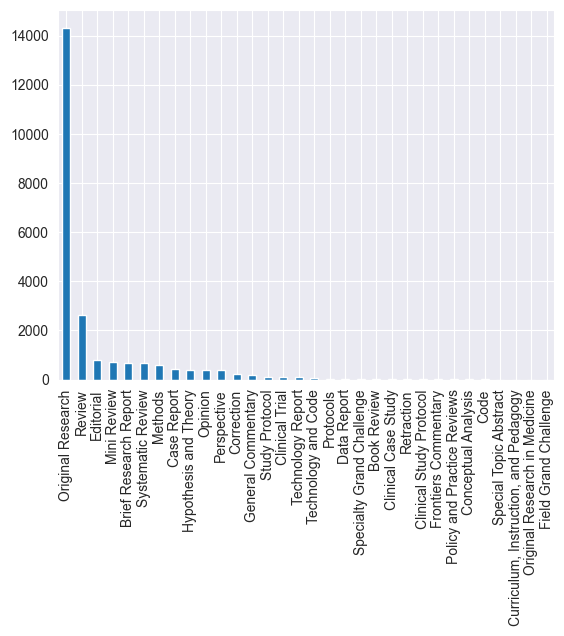

In [48]:
df_describe['article type'].value_counts().plot(kind='bar')

In [ ]:
df_describe['article authors'].value_counts().plot(kind='bar')

In [49]:
df_describe[1].value_counts()

Niels Hansen            9
Yang Liu                9
Xin Li                  8
Wei Li                  8
Javier DeFelipe         8
                       ..
Shouguo Zhao            1
Huiyan Li               1
Marina Chistiakova      1
James Yu-Chang Liao     1
Marieke E. Thurlings    1
Name: 1, Length: 20055, dtype: int64

In [ ]:
df_describe["article date"].value_counts()

<AxesSubplot:>

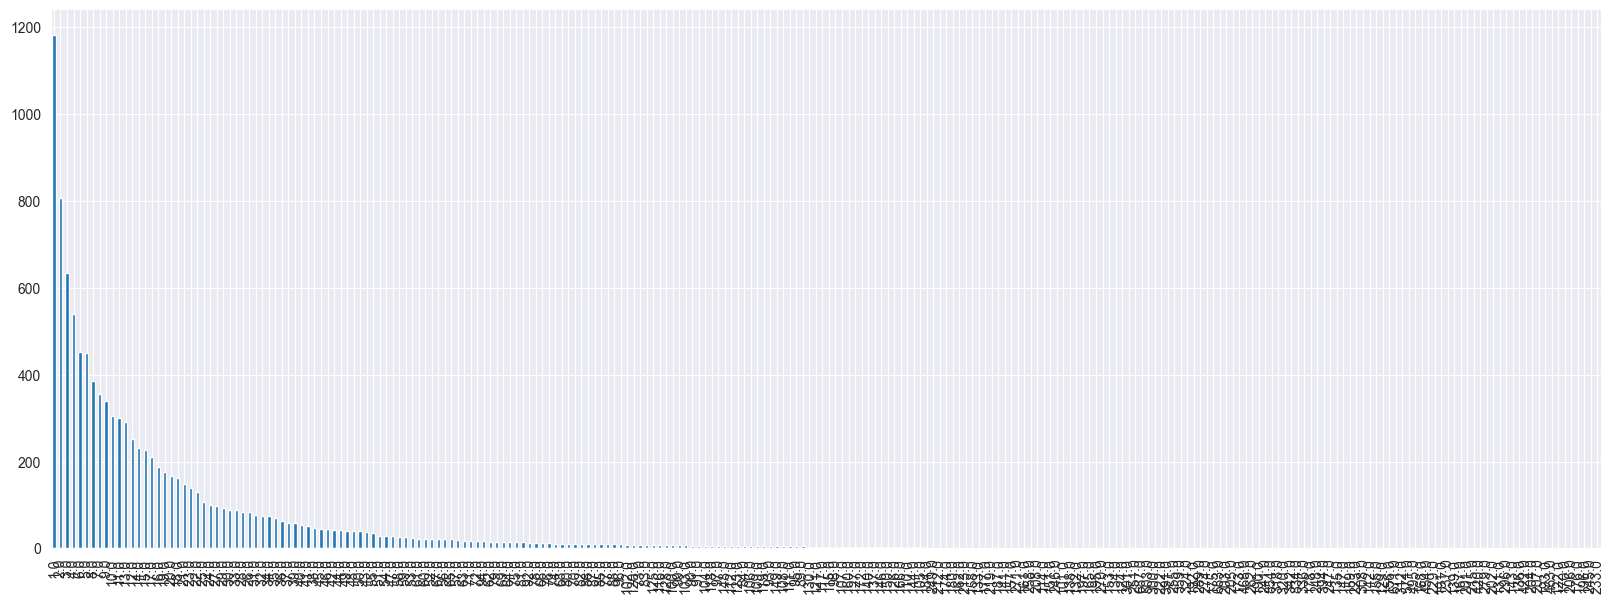

In [53]:
df_describe['citations'].value_counts().plot(kind='bar', figsize=(20,7))

In [ ]:
sns.pairplot(df_describe[['article authors','views', 'citations']])

In [54]:
df_handel_nulls.nlargest(n=10, columns=['citations'])

,article type,article date,article status,article journal,1,2,3,article authors,views,citations,4,5,6,7,8,9,10
"Gradient boosting machines, a tutorial",Methods,2013-12-04,Published,Frontiers in Neurorobotics,Alexey Natekin,Alois Knoll,NaN,2,269440.0,854.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Generating stimuli for neuroscience using PsychoPy,Original Research,2009-01-15,Published,Frontiers in Neuroinformatics,Jonathan W Peirce,NaN,NaN,1,53361.0,834.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Machine learning for neuroimaging with scikit-learn,Methods,2014-02-21,Published,Frontiers in Neuroinformatics,Alexandre Abraham,Fabian Pedregosa,Michael Eickenberg,9,74468.0,687.0,Philippe Gervais,Andreas Mueller,Jean Kossaifi,Alexandre Gramfort,Bertrand Thirion,Gael Varoquaux,NaN
"Nipype: A Flexible, Lightweight and Extensible Neuroimaging Data Processing Framework in Python",Original Research,2011-08-22,Published,Frontiers in Neuroinformatics,Krzysztof Gorgolewski,Christopher D. Burns,Cindee Madison,7,44643.0,683.0,Dav Clark,Yaroslav O. Halchenko,Michael L. Waskom,Satrajit S Ghosh,NaN,NaN,NaN
Unsupervised learning of digit recognition using spike-timing-dependent plasticity,Original Research,2015-08-03,Published,Frontiers in Computational Neuroscience,Peter U. Diehl,Matthew Cook,NaN,2,93520.0,671.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Selective neuronal vulnerability to oxidative stress in the brain,Review,2010-03-30,Published,Frontiers in Aging Neuroscience,Xinkun Wang,Elias K Michaelis,NaN,2,45391.0,571.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Dipy, a library for the analysis of diffusion MRI data",Methods,2014-02-21,Published,Frontiers in Neuroinformatics,Eleftherios Garyfallidis,Matthew Brett,Bagrat Amirbekian,7,41792.0,503.0,Ariel Rokem,Stefan Van Der Walt,Maxime Descoteaux,Ian Nimmo-Smith,NaN,NaN,NaN
Plasticity of Brain Networks in a Randomized Intervention Trial of Exercise Training in Older Adults,Original Research,2010-08-26,Published,Frontiers in Aging Neuroscience,Michelle W Voss,Ruchika S Prakash,Kirk I Erickson,10,77797.0,495.0,Chandramallika Basak,Laura Chaddock,Jennifer S Kim,Heloisa Alves,Susie Heo,Amanda Szabo,Siobhan M White
A Tutorial Review of Functional Connectivity Analysis Methods and Their Interpretational Pitfalls,Review,2016-01-08,Published,Frontiers in Systems Neuroscience,André M. Bastos,Jan-Mathijs Schoffelen,NaN,2,109344.0,468.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Neural synchrony in cortical networks: history, concept and current status",Original Research,2009-07-30,Published,Frontiers in Integrative Neuroscience,Peter Uhlhaas,Gordon Pipa,Bruss Lima,7,43709.0,463.0,Lucia Melloni,Sergio Neuenschwander,Danko Nikolić,Wolf Singer,NaN,NaN,NaN


In [ ]:
df_describe['views'].max()

In [ ]:
df_describe['citations'].max()

In [55]:
df_describe.loc[df_describe['views'] == 3552721.0]

,article type,article date,article status,article journal,1,2,3,article authors,views,citations,4,5,6,7,8,9,10
Feeling How Old I Am: Subjective Age Is Associated With Estimated Brain Age,Original Research,2018-06-07,Published,Frontiers in Aging Neuroscience,Seyul Kwak,Hairin Kim,Jeanyung Chey,4,3552721.0,44.0,Yoosik Youm,NaN,NaN,NaN,NaN,NaN,NaN


array([[<AxesSubplot:title={'center':'article date'}>]], dtype=object)

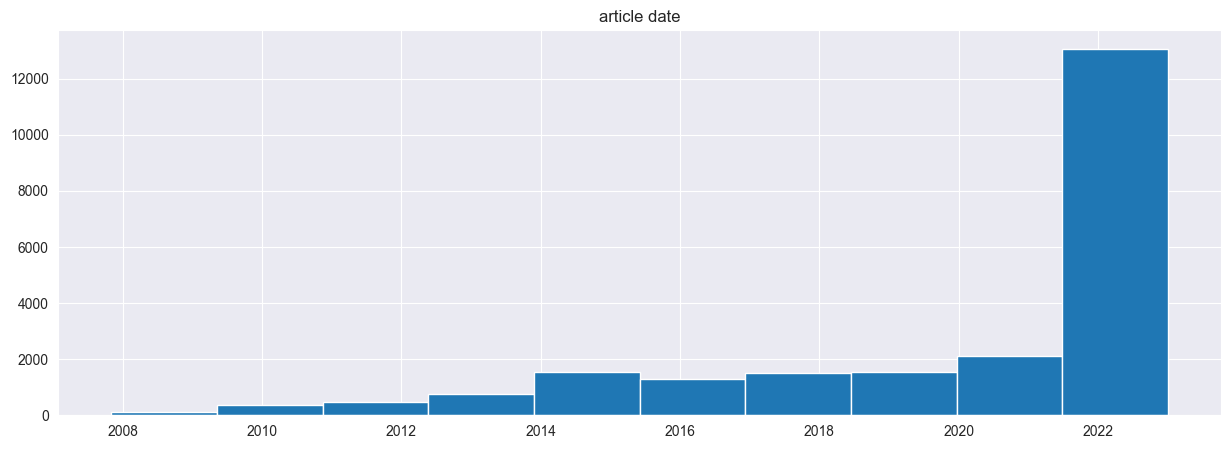

In [56]:
df_describe.hist(figsize=[15, 5])